In [1]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 22.6 MB/s eta 0:00:00


In [12]:
import numpy as np
import torch
from torch_geometric.data import Data
import gymnasium as gym
from gymnasium import spaces
from helpers_functions import *
from gerry_environment import FrankenmanderingEnv
from graph_initiator import build_init_data
import matplotlib.pyplot as plt
import pandas as pd
from random import sample
# from make_grid import Graph

In [3]:
def labels_to_action(labels, num_districts, dtype=np.float32):
    """
    Convert an integer label vector (shape [N]) to an action matrix
    expected by env.step: shape (N, num_districts), each row is
    a 1-hot encoding of the desired district for that voter.
    """
    N = len(labels)
    A = torch.zeros(N, num_districts)
    for i, lab in enumerate(labels):
        if lab >= 0 and lab < num_districts:
            A[i, int(lab)] = 1.0
        else:
            # keep row zeros -> will become -1 label in env.step (avoid if possible)
            pass
    return A

In [4]:
def natural_OD(env, districts, num_districts, drf,geo_edge, Beta1,Beta2):
    assignment = labels_to_action(districts, num_districts)
    obs, reward, terminated, truncated, info = env.step(assignment,drf)
    opinions = np.array(obs.get_x())
    target = np.array(env.get_target())

    dist_target = np.linalg.norm(opinions - target, axis=1).sum()
    #

    # print(f"opinions={opinions}, reward={reward} , distance to target opinion = {dist_target}")

    return obs, reward, dist_target

In [5]:
# random_integers = [random.randint(42, 82) for _ in range(3)]
# for rng in random_integers:
#   init_data, G_graph = build_init_data(K=2,H=4,W=4, opinion_rng = rng)

#   print('edge_attr=',init_data.edge_attr)
#   print('edge_index=',init_data.edge_index)
#   print('opinion=',init_data.x)
#   print('dist_label=',init_data.y)


In [6]:
# env.get_num_districts()


In [41]:
history = []
initi_ops=[]

for j in range (70):
  # This loop generate 70 different social graphs
  H = random.randint(4, 15)
  W = random.randint(4, 10)
  K = 2

  random_integers = sample(range(42, 83), 20)
  #  [random.sample(42, 82) for _ in range(20)]
  # print('len(random_integers)',len(random_integers))
  for i in range(len(random_integers)):
    # this loop goes over 20 different opinion distributions

    init_data, G_graph = build_init_data(K=K,H=H,W=W, opinion_rng = random_integers[i])
    num_voters = init_data.get_x().shape[0]
    dist_label = torch.arange(num_voters)
    target_opinion = torch.full((num_voters,), 7)
    num_districts = num_voters
    initi_ops.append(init_data.get_x())

    # initial environment
    env = FrankenmanderingEnv(num_voters=num_voters,
                            num_districts=num_voters,
                            opinion_dim=1,
                            init_FrankenData=init_data,
                            target_opinion=target_opinion)
    obs, _ = env.reset()
    # do 100 step
    for _ in range(100):
      obs, reward, dist_target = natural_OD(env, dist_label, num_districts, drf_f1, init_data.get_geo_edge(), 0.1,0.5)

      # store data
      history.append({
                'graph_id':j,
                'opnion_id': i,
                'obs': obs,
                'reward':reward,
                'dis_to_target': dist_target,
                'opinion': obs.get_x(),

                })


BA (undirected) edges: 122 (expected m*(N-m) = 2*(63-2) = 122)
SOC directed arcs: 244 (should be 2 * 122 = 244)
BA (undirected) edges: 122 (expected m*(N-m) = 2*(63-2) = 122)
SOC directed arcs: 244 (should be 2 * 122 = 244)
BA (undirected) edges: 122 (expected m*(N-m) = 2*(63-2) = 122)
SOC directed arcs: 244 (should be 2 * 122 = 244)
BA (undirected) edges: 122 (expected m*(N-m) = 2*(63-2) = 122)
SOC directed arcs: 244 (should be 2 * 122 = 244)
BA (undirected) edges: 122 (expected m*(N-m) = 2*(63-2) = 122)
SOC directed arcs: 244 (should be 2 * 122 = 244)
BA (undirected) edges: 122 (expected m*(N-m) = 2*(63-2) = 122)
SOC directed arcs: 244 (should be 2 * 122 = 244)
BA (undirected) edges: 122 (expected m*(N-m) = 2*(63-2) = 122)
SOC directed arcs: 244 (should be 2 * 122 = 244)
BA (undirected) edges: 122 (expected m*(N-m) = 2*(63-2) = 122)
SOC directed arcs: 244 (should be 2 * 122 = 244)
BA (undirected) edges: 122 (expected m*(N-m) = 2*(63-2) = 122)
SOC directed arcs: 244 (should be 2 * 122

In [42]:
df_history = pd.DataFrame(history)
df_history.to_csv('df_history.csv')
len(history)

140000

# **Total sum of all absolute changes in opinions**

In [43]:
# This function shows the sum of changes in opinion for each graph
def total_sum(df, g_number, op_number):
    total_dist = np.zeros((g_number,op_number))
    ops_ids = df_history['opnion_id'].unique()

    for j in range(g_number):
        # move over each graph
        rows = df_history.loc[df_history['graph_id'] == j].reset_index(drop=True)

        for id in ops_ids:
          # move over each opinion
          opinions = rows.loc[rows['opnion_id'] == id, 'opinion']

          if len(opinions) > 1:
            for i in range(len(opinions)-1):
                dist = torch.linalg.norm(opinions.iloc[i+1] - opinions.iloc[i])
                total_dist[j][id] += dist.item()

    return total_dist

In [44]:
distance = total_sum(df_history,70, 20)

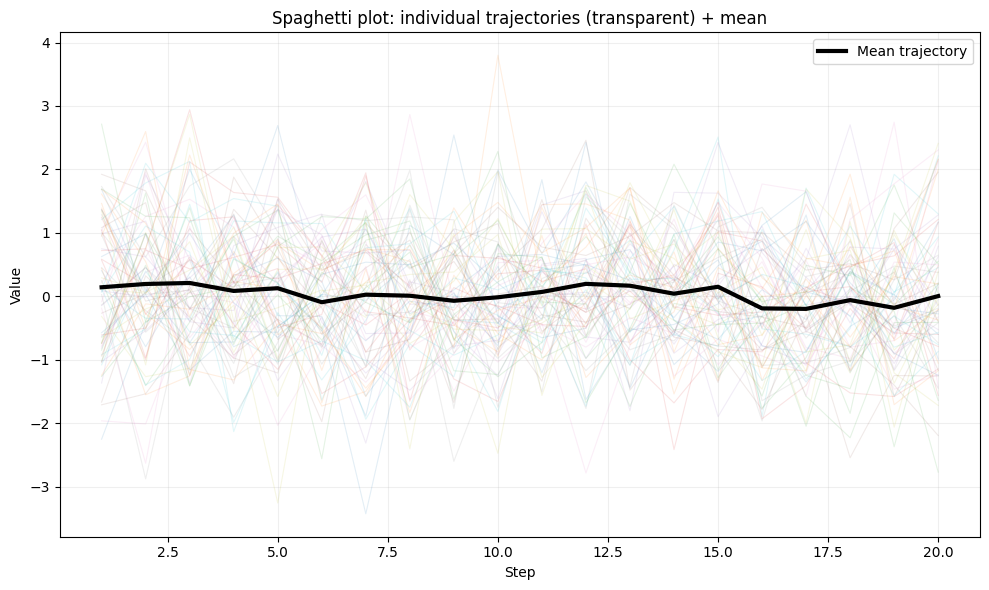

In [45]:

distance = np.random.randn(70, 20)
steps = np.arange(1, distance.shape[1] + 1)

plt.figure(figsize=(10, 6))
for row in distance:
    plt.plot(steps, row, linewidth=0.8, alpha=0.12)
mean_traj = distance.mean(axis=0)
plt.plot(steps, mean_traj, linewidth=3, color='black', label='Mean trajectory')
plt.xlabel('Step')
plt.ylabel('Value')
plt.title('Spaghetti plot: individual trajectories (transparent) + mean')
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()


# **Total distance between initial and end opinions**

In [46]:
# This function calculate the distance between initial opinion and last opinion for each graph
def global_dist(df, g_number, op_number, initi_opinion):
    global_dist = np.zeros((g_number,op_number))
    ops_ids = df_history['opnion_id'].unique()

    for j in range(g_number):
        # move over each graph
        rows = df_history.loc[df_history['graph_id'] == j].reset_index(drop=True)

        for id in ops_ids:
          # move over each opinion
          opinions = rows.loc[rows['opnion_id'] == id, 'opinion']

          # print('count')
          if len(opinions) > 1:
            dist = torch.linalg.norm(initi_opinion[j] - opinions.iloc[-1])
                # print(i)
            global_dist[j][id] = dist.item()

    return global_dist

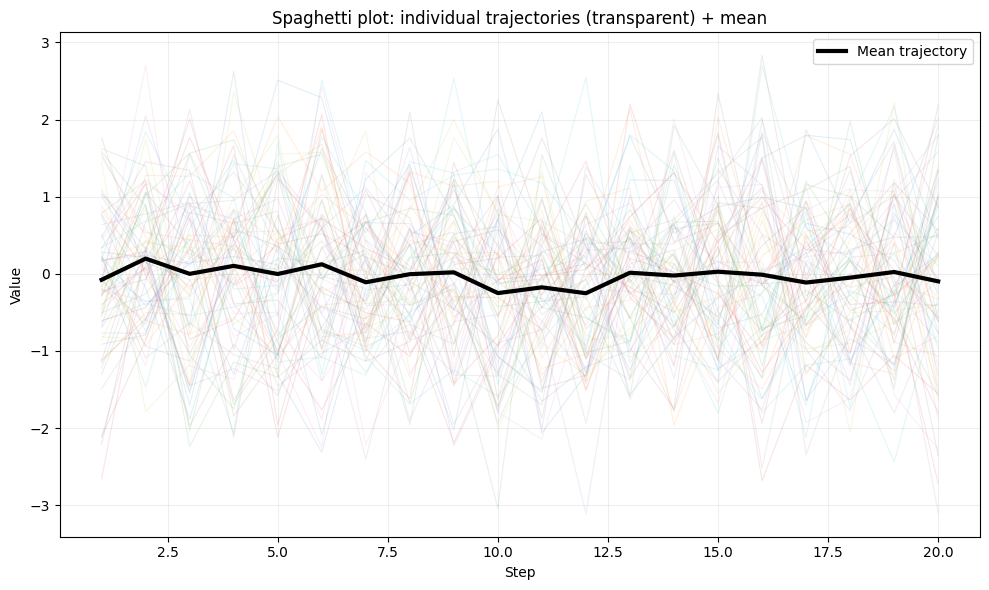

In [47]:
global_distance = global_dist(df_history, 70,20,init_data.get_x())


global_distance = np.random.randn(70, 20)
steps = np.arange(1, global_distance.shape[1] + 1)

plt.figure(figsize=(10, 6))
for row in global_distance:
    plt.plot(steps, row, linewidth=0.8, alpha=0.12)
mean_traj = global_distance.mean(axis=0)
plt.plot(steps, mean_traj, linewidth=3, color='black', label='Mean trajectory')
plt.xlabel('Step')
plt.ylabel('Value')
plt.title('Spaghetti plot: individual trajectories (transparent) + mean')
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()


120